In [1]:
import matplotlib
#matplotlib.use("Agg")  # non-X windows backend

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import os
import time 
import xesmf as xe
import scipy
from scipy import stats
from functools import partial
import intake
import sys
import yaml

from WWE_diag_tools import (
    land_mask_using_etopo,
    regridder_model2obs,
    nharm,
    filter_data,
    isolate_WWEs,
    WWE_characteristics,
    find_WWE_time_lon)

def _preprocess(x, lon_bnds, lat_bnds):
    return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds))

def find_WWEs_and_characteristics(in_data = None, tauu_thresh = 0.04, mintime = 5, minlons = 10,
                                 xminmax = (3, 3), yminmax = (3, 3), minmax_dur_bins = (5, 27),
                                 dur_bin_space = 2, minmax_IWW_bins = (1, 42), IWW_bin_space = 4,
                                 xtend_past_lon = 140):
    '''
    This function call the following functions within WWE_diag_tools.py
    - isolate_WWEs
        - find_nearby_wwes_merge
        - renumber_wwes
    - WWE_chracteristics
    - find_WWE_time_lon
    '''
    
    start_time = time.time()
    
    # 1) Find WWEs
    #The isolate_WWEs function uses the find_nearby_wwes_merge, renumber_wwes functions 
    WWE_labels, WWE_mask = isolate_WWEs(data = in_data, tauu_thresh = tauu_thresh, mintime = mintime, 
                                        minlons = minlons, xmin = xminmax[0], xmax = xminmax[1], 
                                        ymin = yminmax[0], ymax = yminmax[1], xtend_past_lon = xtend_past_lon)

    # 2) Find characteristics (i.e., duration, zonal extent, integrated wind work sum and mean) of each WWE
    #Uses WWE_characteristics function
    duration, zonal_extent, IWW, tauu_mean = WWE_characteristics(wwe_labels = WWE_labels, data = in_data)
    
    # 3) Find central, min, and max time and longitude of each WWE
    #Uses find_WWE_time_lon function
    tauu_time   = in_data["time"]
    tauu_lon    = in_data["lon"]
    lon_array   = np.asarray(tauu_lon)
       
    center_lons, center_times, min_times, max_times, min_lons, max_lons \
    = find_WWE_time_lon(data = in_data, wwe_labels = WWE_labels, 
                         lon = lon_array, time_array = tauu_time)

    print("--- %s seconds to ID WWEs and compute characteristics---" % (time.time() - start_time))
    
    return duration, IWW, zonal_extent, tauu_mean, WWE_labels, WWE_mask, center_lons, \
           center_times, min_times, max_times, min_lons, max_lons, \
           lon_array, tauu_time

def save_filtered_tauu_WWEchar(WWE_labels = None, WWE_mask = None, tauu_anom_vals = None, duration = None, IWW = None,
                               zonal_extent = None,tauu_anom_mean = None, tauu_abs_mean = None, 
                               center_lon_vals = None, center_time_vals = None, min_lon_vals = None, 
                               max_lon_vals = None, min_time_vals = None, max_time_vals = None,
                               lon_array = None, tauu_time = None, save_name = '',
                               filt_descrip = '120-day HP filtered'):
    
    uniq_WWE_labels = np.unique(WWE_labels)[1:]
    #reference_time  = pd.Timestamp('1970-01-01T00:00:00Z')

    data_vars = dict(
        wwe_labels    =(['time', 'lon'], WWE_labels.squeeze(), dict(units='None', long_name='Unique label for each WWE')),
        wwe_mask      =(['time', 'lon'], WWE_mask.squeeze(), dict(units='Binary', long_name='1s are where WWEs are located, 0s are locations without WWEs')),
        tauu_anom     =(['time', 'lon'], tauu_anom_vals.squeeze(), dict(units='Pa', long_name = 'Mean ' + filt_descrip + ' zonal wind stress')),
        tauu_anom_mean=(['events'], tauu_anom_mean, dict(units='Pa', long_name = 'Mean ' + filt_descrip + ' zonal wind stress per WWE')),
        tauu_abs_mean =(['events'], tauu_abs_mean, dict(units='Pa', long_name = 'Mean absolute zonal wind stress per WWE')),
        duration      =(['events'], duration, dict(units='Days', long_name = 'duration of each WWE')),
        IWW_vals      =(['events'], IWW, dict(units='Pa', long_name='Integrated wind work for each WWE')),
        zonal_extent  =(['events'], zonal_extent, dict(units='Degrees', long_name = 'Longitudinal extent of each WWE')),
        center_lons   =(['events'], center_lon_vals, dict(units='Degrees', long_name = 'Mass-weighted center longitude for each WWE')),
        min_lons      =(['events'], min_lon_vals, dict(units='Degrees', long_name = 'Min longitude for each WWE')),
        max_lons      =(['events'], max_lon_vals, dict(units='Degrees', long_name = 'Max longitude for each WWE')),
        min_times     =(['events'], min_time_vals),
        max_times     =(['events'], max_time_vals),
        center_times  =(['events'], center_time_vals)
    )

    ds = xr.Dataset(data_vars = data_vars,
                    coords=dict(
                        events= (["events"], uniq_WWE_labels),
                        lon   = lon_array,
                        time  = tauu_time,
                    ),
                    attrs=dict(description= filt_descrip + " zonal wind stress and WWE characteristics. Generated using MDTF POD WWE diagnostic")
                   )

    ds.to_netcdf(save_name + '.WWE_characteristics.nc')
    
    return ds

def events_per_lon(in_da = None):
    
    nevents    = np.unique(in_da)[1:].size #Don't count zero
    event_nums = np.unique(in_da)[1:]
    
    event_lon_mask = np.zeros(nevents*in_da.lon.size).reshape(nevents, in_da.lon.size)
    var_shape_list = in_da.shape

    for ievent in range(nevents):
        lon_axis  = var_shape_list.index(in_da.lon.shape[0])
        temp_lons = np.zeros(in_da.lon.size)    
        w         = np.where(in_da == event_nums[ievent])
        uniq_wlons= np.unique(w[lon_axis])
        temp_lons[uniq_wlons] = 1
        event_lon_mask[ievent] = temp_lons
        
    count_event_lons = np.sum(event_lon_mask, axis = 0)
    
    return count_event_lons, nevents

In [2]:
# Receive a dictionary of case information from the framework
# Remove following line final PR
os.environ["case_env_file"] = "/Users/eriley/mdtf/wkdir/MDTF_output.v6/WWEs/case_info.yml"
os.environ['CASENAME'] = "CESM2_historical_r1i1p1f1_gn"
os.environ["first_yr"] = "1980"
os.environ["last_yr"]  = "2014"
os.environ["min_lat"]  = "-2.5"
os.environ["max_lat"]  = "2.5"
os.environ["min_lon"]  = "120"
os.environ["max_lon"]  = "280"
os.environ["regrid_method"] =  "conservative_normed"
static_thresh = True

casename  = os.environ["CASENAME"]
first_year= os.environ["first_yr"]
last_year = os.environ["last_yr"]
min_lat   = float(os.environ["min_lat"])
max_lat   = float(os.environ["max_lat"])
min_lon   = float(os.environ["min_lon"])
max_lon   = float(os.environ["max_lon"])
regrid_method = os.environ["regrid_method"]

###########################################################################
##############Part 1: Get & Plot Observations #############################
###########################################################################
print(f'*** Now working on obs data\n------------------------------')
obs_path = '~/mdtf/inputdata/obs_data/WWEs/'
obs_WWEs = xr.open_dataset(obs_path + 'TropFlux_120-dayHPfiltered_tauu_1980-2014.nc')
obs_lons = obs_WWEs.lon
obs_lats = obs_WWEs.lat
obs_time = obs_WWEs.time
Pac_lons = obs_WWEs.Pac_lon
obs_WWE_mask        = obs_WWEs.WWE_mask
TropFlux_filt_tauu  = obs_WWEs.filtered_tauu
TropFlux_WWEsperlon = obs_WWEs.WWEs_per_lon

#Define lats to average tauu over and lon range to analyze
lat_lim_list = [min_lat, max_lat]
lon_lim_list = [min_lon, max_lon]

###########################################################################
############################### Model #####################################
###########################################################################
print(f'*** Now starting work on {casename}\n------------------------------')
print('*** Reading variables ...')


case_env_file = os.environ["case_env_file"]
assert os.path.isfile(case_env_file), f"case environment file not found"
with open(case_env_file, 'r') as stream:
    try:
        case_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

cat_def_file = case_info['CATALOG_FILE']
case_list    = case_info['CASE_LIST']

*** Now working on obs data
------------------------------
*** Now starting work on CESM2_historical_r1i1p1f1_gn
------------------------------
*** Reading variables ...


In [3]:
#Use partial function to only load part of the data file
lon_bnds, lat_bnds = (0, 360), (-32.5, 32.5)
partial_func       = partial(_preprocess, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

# open the csv file using information provided by the catalog definition file
cat = intake.open_esm_datastore(cat_def_file)

# all cases share variable names and dimension coords in this example, so just get first result for each
tauu_var   = [case['tauu_var'] for case in case_list.values()][0]
time_coord = [case['time_coord'] for case in case_list.values()][0]
lat_coord  = [case['lat_coord'] for case in case_list.values()][0]
lon_coord  = [case['lon_coord'] for case in case_list.values()][0]

#########################################################
#Filter catalog by desired variable and output frequency
#########################################################
# filter catalog by desired variable and output frequency
tauu_subset = cat.search(variable_id=tauu_var, frequency="day")
tauu_dict   = tauu_subset.to_dataset_dict(preprocess = partial_func,
                                          xarray_open_kwargs={"decode_times": True, "use_cftime": True})

for k, v in tauu_dict.items(): 
    tauu_arr = tauu_dict[k][tauu_var]

#Get sftlf (land fraction) variable if it exists & mask out land 
key = 'sftlf_var'
x = list(case_list[casename].keys())

if(x.count(key) == 1):
    print("Using model land fraction variable")
    sftlf_var  = [case['sftlf_var'] for case in case_list.values()][0]
    sftlf_subset= cat.search(variable_id=sftlf_var, frequency="fx")
    sftlf_dict = sftlf_subset.to_dataset_dict(preprocess = partial_func)
    
    for k, v in sftlf_dict.items():
        sftlf_arr = sftlf_dict[k][sftlf_var]
        
    masked_tauu = tauu_arr.where(sftlf_arr < 10)

tauu_ds = masked_tauu.to_dataset()

tauu_ds = tauu_ds.where((tauu_ds.time.dt.year >= int(first_year)) &
                       (tauu_ds.time.dt.year <= int(last_year)), drop = True)

tauu_ds["mask"] = xr.where(~np.isnan(tauu_ds[tauu_var].isel(time = 0)), 1, 0)

print('lon size before regridding:', tauu_ds.lon.size)
print('Start regrid code using the following method:', regrid_method)

if tauu_ds.lat.size > 1:
    print('tauu_ds.lat.size > 1')
    regridder_tauu = regridder_model2obs(lon_vals = np.asarray(obs_lons), lat_vals = np.asarray(obs_lats),
                                        in_data = tauu_ds, type_name = regrid_method,
                                        isperiodic = True)
    re_model_tauu   = regridder_tauu(tauu_ds[tauu_var], skipna = True)

print('lon size after regridding:', re_model_tauu.lon.size)

##################################################
#Find region of interest
##################################################
tauu_region = ((re_model_tauu).where(
    (re_model_tauu.lat >= np.array(lat_lim_list).min()) &
    (re_model_tauu.lat <= np.array(lat_lim_list).max()) &
    (re_model_tauu.lon >= np.array(lon_lim_list).min()) &
    (re_model_tauu.lon <= np.array(lon_lim_list).max()),
    drop = True))

##################################################
#Average over the latitudes
##################################################
#The xarray mean function ignores the nans
tauu_region_latavg = tauu_region.mean(dim = 'lat') 
    
###################################################################################
#Check to see if westerly zonal wind stresses are recorded as positive or negative
###################################################################################
mean_lon220p5 = np.array(np.mean(tauu_region_latavg.sel(lon = 220.5)))
print('mean tauu at 220.5E:', mean_lon220p5)
factor = -1 if mean_lon220p5 > 0 else 1
tauu   = tauu_region_latavg * factor
print('tauu after lat averaging:', tauu)
print('At this point, tauu is a DataArray with time longitude dimensions on the TropFlux grid')


###################################################################################
#Filter tauu to use as input to find WWEs and their chracteristics
###################################################################################
#filt_dataLP = filter_data(data = tauu, nweights = 201, a = 5)
#For now the only option is to apply a 120-day highpass filter
filt_dataHP = filter_data(data = tauu, nweights = 201, a = 120) 

data2use        = tauu - filt_dataHP
obs_tauu_thresh = 0.04 #Nm-2 Two standard deviations of the TropFlux lat-averaged 120E-280E zonal wind stress.
tauu_thresh2use = obs_tauu_thresh if static_thresh is True else np.round(data2use.std()*2, decimals = 2)

print('tauu_thresh2use:', tauu_thresh2use)
print('data2use', data2use)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.frequency.member_id.table_id.grid_label.realm.variant_label'


Using model land fraction variable

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.frequency.member_id.table_id.grid_label.realm.variant_label'


/Users/eriley/anaconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xarray/conventions.py:436: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


lon size before regridding: 288
Start regrid code using the following method: conservative_normed
tauu_ds.lat.size > 1


/Users/eriley/anaconda3/envs/_MDTF_python3_base/lib/python3.12/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')


lon size after regridding: 360
mean tauu at 220.5E: -0.05880814732758902
tauu after lat averaging: <xarray.DataArray (time: 12775, lon: 160)>
dask.array<mul, shape=(12775, 160), dtype=float64, chunksize=(1, 160), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 2014-12-31 00:00:00
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 276.5 277.5 278.5 279.5
At this point, tauu is a DataArray with time longitude dimensions on the TropFlux grid
tauu_thresh2use: 0.04
data2use <xarray.DataArray (time: 12775, lon: 160)>
dask.array<sub, shape=(12775, 160), dtype=float64, chunksize=(1, 160), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 2014-12-31 00:00:00
  * lon      (lon) float64 120.5 121.5 122.5 123.5 ... 276.5 277.5 278.5 279.5


In [4]:
#Find WWEs and their characteristics and compute statistics 
duration, IWW, zonal_extent, tauu_mean, WWE_labels, WWE_mask, center_lons, \
center_times, min_times, max_times, min_lons, max_lons, lon_array, tauu_time = \
find_WWEs_and_characteristics(in_data = data2use, tauu_thresh = tauu_thresh2use, mintime = 5, minlons = 10,
                              xminmax = (3, 3), yminmax = (3, 3), minmax_dur_bins = (5, 27),
                              dur_bin_space = 2, minmax_IWW_bins = (1, 42), IWW_bin_space = 4,
                              xtend_past_lon = 140)

durationB, zonal_extentB, tauu_sum, tauu_abs_mean = WWE_characteristics(wwe_labels = WWE_labels, data = tauu) #ds[tauu_name])

--- 264.45891308784485 seconds to ID WWEs and compute characteristics---


In [29]:
save_name = f"{casename}.{first_year}-{last_year}"
####################################################################
# Save the WWE characteristics and statistics to a netcdf file
####################################################################   
WWE_chars = save_filtered_tauu_WWEchar(WWE_labels = WWE_labels, WWE_mask = WWE_mask, tauu_anom_vals = np.asarray(data2use), 
                                       duration = duration, IWW = IWW, zonal_extent = zonal_extent, 
                                       tauu_anom_mean = tauu_mean, tauu_abs_mean = tauu_abs_mean, 
                                       center_lon_vals = center_lons, center_time_vals = np.asarray(center_times), 
                                       min_lon_vals = min_lons, max_lon_vals = max_lons, 
                                       min_time_vals = np.asarray(min_times), max_time_vals = np.asarray(max_times), 
                                       lon_array = lon_array, tauu_time = np.asarray(tauu_time), save_name = save_name)

In [42]:
WWE_labels_da = xr.DataArray(data=WWE_labels, dims = ['time', 'lon'], 
                                 coords=dict(
                                     lon=(['lon'], lon_array),
                                     time=tauu_time,),
                                 attrs=dict(description="WWE labels", units = 'N/A',)
                                )
count_all_event_lons, nall_events = events_per_lon(in_da = WWE_labels_da)

obs_prop_per_day   = TropFlux_WWEsperlon/obs_time.size*100.
model_prop_per_day = count_all_event_lons/tauu_time.size*100.

model_titlename = f"{casename} {first_year}-{last_year}"

In [47]:
data_vars = dict(
    model_WWEs_per_lon      =(['lon'], count_all_event_lons, dict(units='count', long_name='Number of unique WWEs affecting a 1degree lon bin from the model')),
    model_freq_WWEs_per_lon =(['lon'], model_prop_per_day,  dict(units='fractuion', long_name='The fraction of unique WWEs affecting a 1degree lon bin from the model calculated as count/ndays ')),
    obs_WWEs_per_lon        =(['lon'], np.asarray(TropFlux_WWEsperlon), dict(units='count', long_name='Number of unique WWEs affecting a 1degree lon bin in TropFlux observations from 1980-2014')),
    obs_freq_WWEs_per_lon   =(['lon'], np.asarray(obs_prop_per_day),  dict(units='fractuion', long_name='The fraction of unique WWEs affecting a 1degree lon bin from TropFlux calculated as count/ndays '))
)
 
ds = xr.Dataset(data_vars = data_vars,
                coords=dict(lon = lon_array,),
                    attrs=dict(description= "Variables needed to make the *model*_and_TropFlux_WWE_prob_per_day.png figures that the WWEs POD produces")
                   )

ds.to_netcdf(casename + '_and_TropFlux_WWE_prob_per_day.nc')


In [38]:
def plot_WWE_likelihood_per_lon(lons = None, model_prop_per_day = None,
                                obs_prop_per_day = None, model_name = '',
                                first_year = '', last_year = ''):
    
    fig, ax = plt.subplots(figsize=(6, 4))
    cf = ax.plot(lons, model_prop_per_day)
    cf = ax.fill_between(lons, model_prop_per_day*0, model_prop_per_day, alpha=0.9, label = model_name)
    cf2 = ax.plot(lons, obs_prop_per_day, color = 'gray')
    cf2 = ax.fill_between(lons, obs_prop_per_day*0, obs_prop_per_day, color = 'gray', alpha = 0.7, label = 'TropFlux observations')
    
    ax.legend(fontsize = 12)
    
    ax.set_title(model_titlename, fontsize = 14)
    ax.set_xlabel('longitude', fontsize = 14)
    ax.set_ylabel('Probability per day (%)', fontsize = 14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.set_ylim(0, 1.8)
    ax.grid(alpha = 0.5)

    #Add second axis
    ax2 = ax.twinx()
    ytick_vals = ax.get_yticks()
    ytick_vals[-1] = 1.8
    label = np.around(100/ytick_vals, decimals = 1)
    label = ['inf', '200.0', '100.0', '66.7', '']
    ax2.set_yticks(ytick_vals)
    ax2.set_yticklabels(label, fontsize = 14)
    ax2.set_xlabel('Longitude', fontsize = 14)
    ax2.set_ylabel('Rate of return (days)', fontsize = 14)
    plt.savefig(f"{model_name}_and_TropFlux_WWE_prob_per_day_{first_year}-{last_year}.png", bbox_inches='tight')

    return cf

/var/folders/bx/ck1jzpsn3t9flxhnk_53pkdc0001zx/T/ipykernel_69588/117502478.py:25: RuntimeWarning: divide by zero encountered in divide
  label = np.around(100/ytick_vals, decimals = 1)


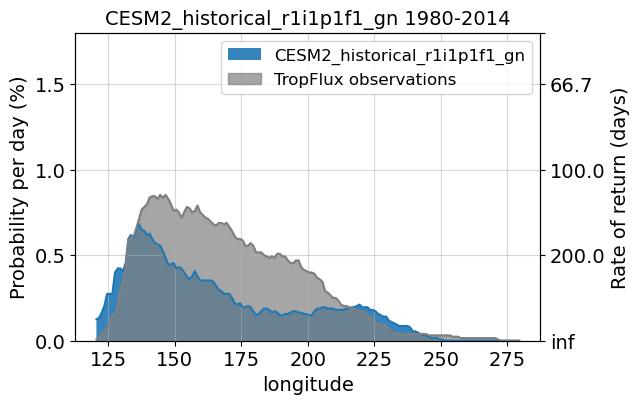

In [39]:
plot_WWE_likelihood_per_lon(lons = Pac_lons, model_prop_per_day = model_prop_per_day,
                            obs_prop_per_day = obs_prop_per_day, model_name = casename,
                           first_year = first_year, last_year = last_year)

In [ ]:
def compute_plot_WWE_likelihood_per_lon(WWE_labels = None, lons = None, times = None,
                                        obs_WWE_labels_da = None, ref_width = 4, 
                                        ref_aspect = (3, 2), model_name = '', fig_width = 4,
                                        save_name = ''):
    
    fig, ax = plt.subplots(figsize=(5.5, 4))
            
    WWE_labels_da = xr.DataArray(data=WWE_labels, dims = ['time', 'lon'], 
                                 coords=dict(
                                     lon=(['lon'], lons[i]),
                                     time=times,),
                                 attrs=dict(description="WWE labels", units = 'N/A',)
                                )
        
    count_all_event_lons, nall_events = events_per_lon(in_da = WWE_labels_da)

    #Make into a panda structure for easier plotting
    pd_struc_all = pd.DataFrame(count_all_event_lons, columns = pd.Index([model_name[i]]),
                                index = pd.Index(WWE_labels_da.lon, name = 'Longitude'))
      
    cb = ax.area(pd_struc/WWE_labels.time.size*100., label = model_name[i], alpha = 0.99)
    cb = ax.area(obs_pd_struc/obs_WWE_labels.time.size*100., 
                    alpha = 0.7, color ='gray', label = 'TropFlux')
            
    ax.format(ylim = (0, 1.8), xlim = (110, 280), 
                 title = model_name[i], titleloc = 'l')
    ax.legend(loc='ur', ncols = 1, prop={"size":7})
              
            ax2 = ax[i].twinx()
            ytick_vals = ax[i].get_yticks()
            ytick_vals[-1] = 1.8
            label = np.around(100/ytick_vals, decimals = 1)
            label = ['inf', '200.0', '100.0', '66.7', '']
            ax2.set_yticks(ytick_vals)
            ax2.set_yticklabels(label, fontsize = 10)
            ax2.set_xlabel('Longitude', fontsize = 10)
                
    ax.format(abc = 'a)', titlesize = 10, fontsize = 10, xlabel = 'Longitude',
              ylabel = 'Probability per day (%)')
        
    fig.save('Hists_Longitude_Points_inWWEs'+save_name+'.png')
        
    return cb

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
cf = ax.plot(Pac_lons, model_prop_per_day)
cf = ax.fill_between(Pac_lons, model_prop_per_day*0, model_prop_per_day, alpha=0.9, label = casename)
cf2 = ax.plot(Pac_lons, obs_prop_per_day, color = 'gray')
cf2 = ax.fill_between(Pac_lons, obs_prop_per_day*0, obs_prop_per_day, color = 'gray', alpha = 0.7, label = 'TropFlux observations')
    
ax.legend(fontsize = 12)
    
ax.set_title(model_titlename, fontsize = 14)
ax.set_xlabel('longitude', fontsize = 14)
ax.set_ylabel('Probability per day (%)', fontsize = 14)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_ylim(0, 1.8)
ax.grid(alpha = 0.5)

#Add second y axis
ax2 = ax.twinx()
ytick_vals = ax.get_yticks()
ytick_vals[-1] = 1.8
label = np.around(100/ytick_vals, decimals = 1)
label = ['inf', '200.0', '100.0', '66.7', '']
ax2.set_yticks(ytick_vals)
ax2.set_yticklabels(label, fontsize = 14)
ax2.set_xlabel('Longitude', fontsize = 14)
ax2.set_ylabel('Rate of return (days)', fontsize = 14)
plt.savefig('test_WWE_prob_per_day.png', bbox_inches='tight')